In [227]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from dataset_utils import Format_Dataset
from tqdm import tqdm

In [228]:
# Load in the Indianapolis Glaucoma Progression Study
data_dir = 'data/IGPS/'
results_dir = 'results/IGPS/'

features = [
    'IOP', 'MAP', 'SBP', 'DBP', 'HR', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'Age', 'BMI', 'mean_RNFL_thickness'
]

first, igps = True, None
for fn in sorted(os.listdir(data_dir)):
    if fn.endswith('.csv'):
        path = os.path.join(data_dir, fn)

        if first:
            igps = pd.read_csv(path)[features]  # grab only the features needed
            first = False
            continue

        df = pd.read_csv(path)[features]
        igps = pd.concat([igps, df])

# Some missing data; lets fix it
def impute_col_KNN(df, col_name):
    col = df[[col_name]]
    imputer = KNNImputer(n_neighbors=3)
    col = imputer.fit_transform(col)
    df[col_name] = col

for f in features:
    impute_col_KNN(igps, f)

print(igps.shape)

igps

(621, 15)


,IOP,MAP,SBP,DBP,HR,Qmean,P1,P2,P4,P5,R4,R5,Age,BMI,mean_RNFL_thickness
0,20.0,101.000000,131.0,86.0,72.0,0.000750,47.489951,38.966147,23.876599,19.316454,5689.152456,3574.568059,68.172485,28.481307,0.28
1,18.0,88.330000,115.0,75.0,92.0,0.000645,41.983253,34.646439,21.624255,18.571021,5763.809295,2381.464597,68.501027,33.017818,0.27
2,12.0,92.670000,122.0,78.0,56.0,0.000712,43.567630,35.482030,21.690086,19.048322,4121.464174,2229.961801,58.231348,25.948481,0.21
3,13.0,105.670000,147.0,85.0,79.0,0.000884,50.544863,40.528359,23.477115,20.265924,3952.890670,2229.632004,75.148528,23.552727,0.25
4,20.0,104.000000,160.0,76.0,79.0,0.000919,53.856285,43.438934,25.149518,20.514162,5312.669706,2982.669157,71.887748,33.788995,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,17.0,89.000000,105.0,81.0,87.0,0.000598,39.823806,33.008874,20.944882,18.243175,5652.671323,2239.016812,72.490075,37.247373,0.15
65,14.0,84.000000,118.0,67.0,68.0,0.000659,41.748648,34.257426,21.306521,18.673210,4689.228002,2233.608849,38.661191,20.510177,0.04
66,4.0,99.000000,135.0,81.0,61.0,0.000816,46.703749,37.462362,22.224339,19.787909,2674.666564,2217.205309,82.762491,23.914334,0.17
67,21.0,87.666667,109.0,77.0,78.0,0.000562,41.925701,35.519931,24.128418,17.987417,5940.162774,6414.302059,72.361396,25.220102,0.18


In [229]:
# Preprocess this mess
split = int(0.8 * len(igps))
train = igps.iloc[:split]
test = igps.iloc[split:]

# feat_count = 18
feat_count = len(features) - 1
print(feat_count)

# transform with the labels still in place
s = MinMaxScaler()
train = s.fit_transform(train)
test = s.transform(test)

train_X, train_y = train[:, :feat_count], train[:, feat_count:]
test_X, test_y = test[:, :feat_count], test[:, feat_count:]

# train_X, train_y = train_X.to_numpy(), train_y.to_numpy()
# test_X, test_y = test_X.to_numpy(), test_y.to_numpy()

print(train_X.shape)
print(test_X.shape)

print(train_y.shape)
print(test_y.shape)

dataset = {
    'samples': train_X,
    'labels': train_y
}
# online learning due to batch size = 1
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=10)

14
(496, 14)
(125, 14)
(496, 1)
(125, 1)


In [230]:
# Pull the first visit to initialize the RBF since these are the "verified clusters"
first_visit = pd.read_csv(data_dir + 'year0_0.csv')[features]

for f in features:
    impute_col_KNN(first_visit, f)

first_visit = s.transform(first_visit)
first_visit = first_visit[:, :-1]
print(first_visit.shape)

params = {
    'k': 3,  # this cluster number is pre verified
    'data': first_visit,
    'sigma': 0.75,
    'mode': 2  # 0 = single sigma
               # 1 = one sigma per cluster
               # 2 = full covariance matrix
}

rbf = nets.RBF(**params)
loss_fn = nn.MSELoss()  # we are doing regression
# optimizer = optim.SGD(rbf.parameters(), lr=0.1)
optimizer = optim.Adam(rbf.parameters(), lr=0.1)

list(rbf.parameters())

(69, 14)


[Parameter containing:
 tensor([[[0.2295, 0.2351, 0.0139, 0.2068, 0.4089, 0.1998, 0.5970, 0.0653,
           0.6450, 0.3004, 0.2219, 0.5814, 0.3818, 0.3570],
          [0.4534, 0.3633, 0.0639, 0.2693, 0.1873, 0.7055, 0.6177, 0.5910,
           0.2856, 0.4750, 0.2529, 0.4731, 0.2446, 0.3400],
          [0.4018, 0.0554, 0.5944, 0.1980, 0.7080, 0.5837, 0.0509, 0.4884,
           0.4709, 0.5084, 0.0787, 0.6614, 0.2320, 0.5816],
          [0.2969, 0.0055, 0.2312, 0.7392, 0.1708, 0.7081, 0.3509, 0.2684,
           0.4284, 0.2214, 0.5837, 0.4982, 0.4762, 0.0042],
          [0.0446, 0.7049, 0.7148, 0.4180, 0.5235, 0.3510, 0.4097, 0.4672,
           0.1380, 0.4764, 0.0347, 0.3298, 0.5366, 0.0554],
          [0.6608, 0.0246, 0.1931, 0.1876, 0.4796, 0.2914, 0.5869, 0.6267,
           0.4057, 0.4101, 0.7494, 0.2265, 0.6836, 0.5699],
          [0.5346, 0.2653, 0.4782, 0.7247, 0.4737, 0.3136, 0.5003, 0.7182,
           0.2095, 0.4367, 0.2237, 0.0594, 0.3234, 0.7025],
          [0.3745, 0.5056, 0.699

Training... : 100%|██████████| 20/20 [00:01<00:00, 17.64it/s]


[0.018857841578212034, 0.017231165185234966, 0.01718911613127828, 0.017205361422005808, 0.017177208498722306, 0.017142341669223685, 0.01863927432506584, 0.01727544434014208, 0.017496176842002338, 0.01740577517513832, 0.017323019182781115, 0.0173022778689209, 0.017306558632959382, 0.017307011628388203, 0.017308536783212886, 0.01730016221951556, 0.017284108915979434, 0.017271812081878224, 0.017271609888046525, 0.017253674608702953]


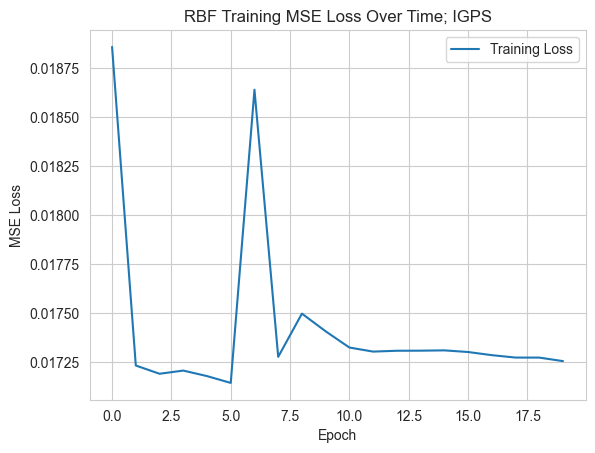

In [231]:
epochs = 20

loss_vals = []
for epoch in tqdm(range(epochs), 'Training... '):
    temp_loss = []
    for samples, labels in train:
        output = rbf(samples)
        loss = loss_fn(output, labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        temp_loss.append(loss.item())

    loss_vals.append(sum(temp_loss[-len(train):]) / len(train))

print(loss_vals)

plt.plot(loss_vals, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('RBF Training MSE Loss Over Time; IGPS')
plt.legend()
plt.savefig(results_dir + 'IGPS_RBF_nn_MSEloss.png', dpi=900)
plt.show()

In [232]:
rbf.eval()
with torch.no_grad():
    out = rbf(torch.tensor(test_X)).detach().numpy()

print(rbf.sigs)
print(out.shape)

preds = []
for i in range(len(out)):
    preds.append(out[i])

Parameter containing:
tensor([[[-1.0975e+00, -8.4318e-01, -1.0147e+00,  4.3347e-01,  1.6516e+00,
           1.9155e+00,  1.9490e+00,  6.3078e-01, -3.0019e-02,  1.0475e+00,
          -1.5820e+00,  2.9963e+00, -1.5031e+00,  4.4921e-01],
         [-9.8143e-01, -1.0326e+00, -4.2044e-01, -3.2686e-01,  4.5064e-01,
           2.2788e+00,  2.9058e+00,  1.0472e+00, -9.3419e-01, -7.4767e-02,
          -4.7700e-01,  1.4603e+00,  2.4136e+00,  3.8689e+00],
         [-5.7810e-01, -3.2593e-02, -1.0748e+00, -1.1610e-01,  1.5083e+00,
           1.6152e+00, -1.7194e-01,  5.9588e-01,  4.0310e-01, -3.6327e-03,
          -1.9756e+00,  3.8983e+00, -1.6452e+00,  2.4884e-01],
         [-3.1058e+00, -1.5650e+00, -1.7539e+00, -8.2324e-01, -3.6668e-01,
           1.1379e+00,  3.5118e+00,  2.5055e+00,  2.3168e+00, -6.8790e-02,
          -1.4611e+00,  2.2800e-01, -5.1867e-01,  1.2911e+00],
         [ 1.9413e-01,  1.3854e+00, -2.0354e+00, -1.0907e+00, -1.1561e+00,
          -2.1279e+00, -3.0534e-01,  1.7503e+00,  7

Mean Squared Error (MSE): 0.018355849383258453
Mean Absolute Error (MAE): 0.10575330750196602
R-squared (R2) Score: -0.0053554120513266135


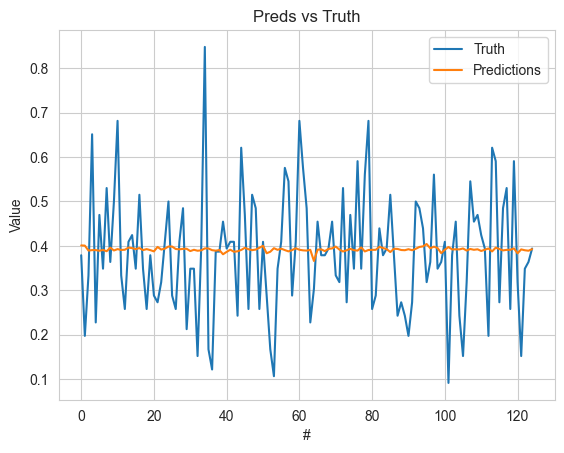

In [233]:
truth = list(test_y)

mse = mean_squared_error(truth, preds)
print("Mean Squared Error (MSE):", mse)

mae = mean_absolute_error(truth, preds)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(truth, preds)
print("R-squared (R2) Score:", r2)

plt.plot(truth, label='Truth')
plt.plot(preds, label='Predictions')
plt.xlabel('#')
plt.ylabel('Value')
plt.title('Preds vs Truth')
plt.legend()
plt.savefig(results_dir + 'IGPS_RBF_nn_regression_predsvtruth.png', dpi=900)
plt.show()